# Importing all the necessary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import warnings
import time
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [2]:
def load_data():
    """
    Load the training data
    """
    try:
        df = pd.read_csv('train.csv')
        print("Data loaded successfully!")
        return df
    except FileNotFoundError:
        print("File not found.")
        return None

# Load the data
df = load_data()

if df is not None:
    # Basic data exploration
    print("Dataset Shape:", df.shape)
    print("First 5 rows:")
    print(df.head())
    
    print("\nColumn Information:")
    print(df.info())
    
    print("\n Basic Statistics:")
    print(df.describe())

Data loaded successfully!
Dataset Shape: (75000, 4)
First 5 rows:
   sample_id                                    catalog_content  \
0      33127  Item Name: La Victoria Green Taco Sauce Mild, ...   
1     198967  Item Name: Salerno Cookies, The Original Butte...   
2     261251  Item Name: Bear Creek Hearty Soup Bowl, Creamy...   
3      55858  Item Name: Judee’s Blue Cheese Powder 11.25 oz...   
4     292686  Item Name: kedem Sherry Cooking Wine, 12.7 Oun...   

                                          image_link  price  
0  https://m.media-amazon.com/images/I/51mo8htwTH...   4.89  
1  https://m.media-amazon.com/images/I/71YtriIHAA...  13.12  
2  https://m.media-amazon.com/images/I/51+PFEe-w-...   1.97  
3  https://m.media-amazon.com/images/I/41mu0HAToD...  30.34  
4  https://m.media-amazon.com/images/I/41sA037+Qv...  66.49  

Column Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null

In [3]:
# Define the function
def extract_text_features(df):
    """
    Extract features from the catalog_content text column
    """
    df_processed = df.copy()
    
    print("EXTRACTING TEXT FEATURES FROM CATALOG_CONTENT")
    print("=" * 45)
    
    if 'catalog_content' in df_processed.columns:
        # Basic text statistics
        df_processed['text_length'] = df_processed['catalog_content'].str.len().fillna(0)
        df_processed['word_count'] = df_processed['catalog_content'].str.split().str.len().fillna(0)
        
        # Product category indicators
        categories = {
            'has_meat': ['meat', 'beef', 'chicken', 'pork', 'sausage', 'bacon'],
            'has_cheese': ['cheese', 'cheddar', 'gouda', 'swiss'],
            'has_snack': ['snack', 'candy', 'chocolate', 'gummy', 'taffy'],
            'has_beverage': ['juice', 'coffee', 'tea', 'drink', 'water'],
            'has_spice': ['spice', 'seasoning', 'pepper', 'cumin', 'cinnamon'],
            'has_organic': ['organic', 'natural', 'non-gmo'],
            'has_gluten_free': ['gluten free', 'gluten-free'],
            'has_vegan': ['vegan', 'plant-based'],
            'has_kosher': ['kosher']
        }
        
        for feature, keywords in categories.items():
            pattern = '|'.join(keywords)
            df_processed[feature] = df_processed['catalog_content'].str.contains(
                pattern, case=False, na=False
            ).astype(int)
            print(f"  Created feature: {feature}")
        
        # Price indicators from text
        price_indicators = {
            'has_premium': ['premium', 'gourmet', 'artisanal', 'handcrafted'],
            'has_bulk': ['bulk', 'large', 'family', 'pack', 'value'],
            'has_small': ['small', 'mini', 'travel', 'sample']
        }
        
        for feature, keywords in price_indicators.items():
            pattern = '|'.join(keywords)
            df_processed[feature] = df_processed['catalog_content'].str.contains(
                pattern, case=False, na=False
            ).astype(int)
        
        print(f"Added {len(categories) + len(price_indicators) + 2} text-based features")
        
    return df_processed

if df is not None:
    print("TESTING TEXT FEATURE EXTRACTION:")
    print("=" * 40)
    df_with_text_features = extract_text_features(df)
    print(f"Original shape: {df.shape}")
    print(f"With text features shape: {df_with_text_features.shape}")
    print("\nNew columns created:")
    new_cols = set(df_with_text_features.columns) - set(df.columns)
    print(list(new_cols))

TESTING TEXT FEATURE EXTRACTION:
EXTRACTING TEXT FEATURES FROM CATALOG_CONTENT
  Created feature: has_meat
  Created feature: has_cheese
  Created feature: has_snack
  Created feature: has_beverage
  Created feature: has_spice
  Created feature: has_organic
  Created feature: has_gluten_free
  Created feature: has_vegan
  Created feature: has_kosher
Added 14 text-based features
Original shape: (75000, 4)
With text features shape: (75000, 18)

New columns created:
['has_gluten_free', 'has_meat', 'has_spice', 'has_beverage', 'has_bulk', 'has_small', 'word_count', 'has_vegan', 'has_snack', 'has_kosher', 'text_length', 'has_cheese', 'has_premium', 'has_organic']


# Data Quality Check and Missing Values Analysis

In [4]:
def check_data_quality(df):
    """
    Comprehensive data quality assessment
    """
    print(" DATA QUALITY REPORT")
    print("=" * 50)
    
    # Missing values
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    
    missing_info = pd.DataFrame({
        'Missing Count': missing_data,
        'Missing Percentage': missing_percent
    }).sort_values('Missing Count', ascending=False)
    
    print(" Missing Values Analysis:")
    print(missing_info[missing_info['Missing Count'] > 0])
    
    # Duplicate check
    duplicates = df.duplicated().sum()
    print(f"\n Duplicate Rows: {duplicates}")
    
    # Data types
    print(f"\n Data Types:")
    print(df.dtypes.value_counts())
    
    return missing_info

# Run data quality check
if df is not None:
    missing_info = check_data_quality(df)

 DATA QUALITY REPORT
 Missing Values Analysis:
Empty DataFrame
Columns: [Missing Count, Missing Percentage]
Index: []

 Duplicate Rows: 0

 Data Types:
object     2
int64      1
float64    1
Name: count, dtype: int64


# Create QQ Plots for Numerical Variables

 Creating QQ plots for: ['sample_id', 'price']


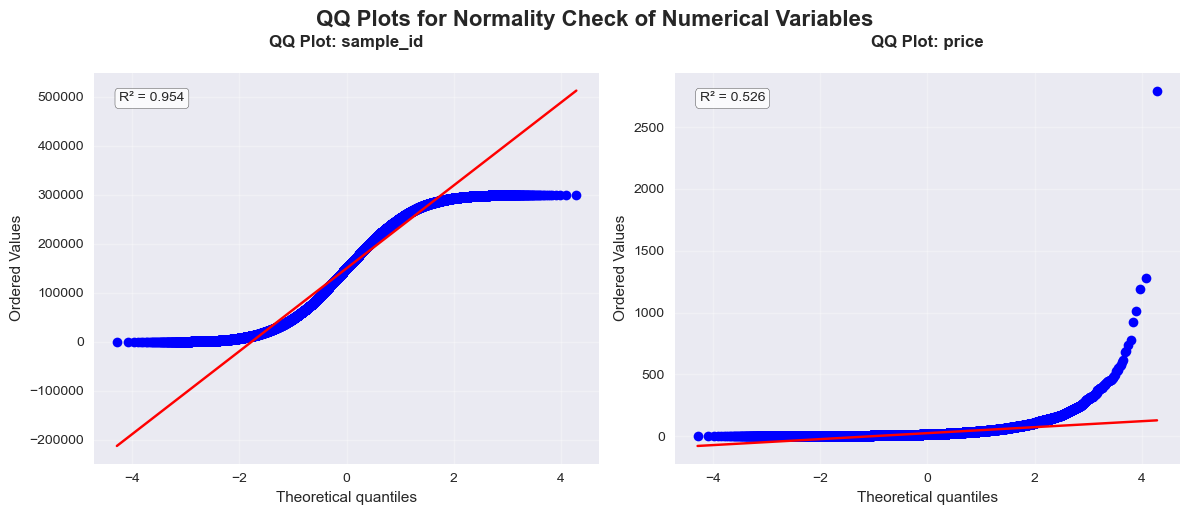


 INTERPRETATION GUIDE:
• Points following the red line = Normal distribution
• Points deviating from line = Non-normal distribution
• Higher R² = Better fit to normal distribution


In [5]:
def create_qqplots_fixed(df, numerical_columns=None, figsize=(12, 5)):
    """
    Create QQ plots to check normality of numerical variables - FIXED VERSION
    """
    # If no numerical_columns provided, auto-detect them
    if numerical_columns is None:
        numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Filter only numerical columns that exist in the dataset
    numerical_cols = [col for col in numerical_columns if col in df.columns]
    
    if not numerical_cols:
        print("No numerical columns found for QQ plots")
        return
    
    print(f" Creating QQ plots for: {numerical_cols}")
    
    n_cols = len(numerical_cols)
    fig, axes = plt.subplots(1, n_cols, figsize=figsize)
    
    # If only one column, make axes a list for consistent indexing
    if n_cols == 1:
        axes = [axes]
    
    for idx, col in enumerate(numerical_cols):
        # Remove missing values for QQ plot
        data = df[col].dropna()
        
        # Create QQ plot
        stats.probplot(data, dist="norm", plot=axes[idx])
        axes[idx].set_title(f'QQ Plot: {col}\n', fontsize=12, fontweight='bold')
        axes[idx].grid(True, alpha=0.3)
        
        # Add R² value to show how well data fits normal distribution
        (osm, osr), (slope, intercept, r) = stats.probplot(data, dist="norm")
        axes[idx].text(0.05, 0.95, f'R² = {r**2:.3f}', transform=axes[idx].transAxes,
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                      verticalalignment='top')
    
    plt.tight_layout()
    plt.suptitle('QQ Plots for Normality Check of Numerical Variables', 
                 y=1.02, fontsize=16, fontweight='bold')
    plt.show()
    
    # Print interpretation
    print("\n INTERPRETATION GUIDE:")
    print("• Points following the red line = Normal distribution")
    print("• Points deviating from line = Non-normal distribution")
    print("• Higher R² = Better fit to normal distribution")

# Create fixed QQ plots - AUTO-DETECT numerical columns
if df is not None:
    create_qqplots_fixed(df)  # No need to pass numerical_columns

In [6]:
def enhanced_analysis_limited_cols(df, numerical_columns):
    """
    Enhanced analysis when we have limited numerical columns
    """
    print(" ENHANCED ANALYSIS FOR LIMITED NUMERICAL COLUMNS")
    print("=" * 50)
    
    numerical_cols = [col for col in numerical_columns if col in df.columns]
    
    for col in numerical_cols:
        print(f"\n Analysis for '{col}':")
        data = df[col].dropna()
        
        # Basic stats
        print(f"  Count: {len(data):,}")
        print(f"  Mean: {data.mean():.2f}")
        print(f"  Std: {data.std():.2f}")
        print(f"  Min: {data.min():.2f}")
        print(f"  Max: {data.max():.2f}")
        print(f"  Missing: {df[col].isnull().sum()}")
        
        # Normality test
        from scipy.stats import shapiro
        if len(data) > 3 and len(data) < 5000:  # Shapiro-Wilk works best for n < 5000
            stat, p_value = shapiro(data)
            print(f"  Shapiro-Wilk p-value: {p_value:.4f}")
            if p_value > 0.05:
                print("  Data appears normally distributed (p > 0.05)")
            else:
                print("  Data does NOT appear normally distributed (p ≤ 0.05)")
        else:
            print("  Sample size outside optimal range for Shapiro-Wilk test")

# Run enhanced analysis
if df is not None:
    numerical_columns = df.select_dtypes(include=[np.number]).columns.tolist()
    print(f"Numerical columns: {numerical_columns}")
    
    if numerical_columns:
        enhanced_analysis_limited_cols(df, numerical_columns)

Numerical columns: ['sample_id', 'price']
 ENHANCED ANALYSIS FOR LIMITED NUMERICAL COLUMNS

 Analysis for 'sample_id':
  Count: 75,000
  Mean: 149841.92
  Std: 86585.35
  Min: 0.00
  Max: 299438.00
  Missing: 0
  Sample size outside optimal range for Shapiro-Wilk test

 Analysis for 'price':
  Count: 75,000
  Mean: 23.65
  Std: 33.38
  Min: 0.13
  Max: 2796.00
  Missing: 0
  Sample size outside optimal range for Shapiro-Wilk test


# Outlier Detection

 Creating box plots for: ['sample_id', 'price']


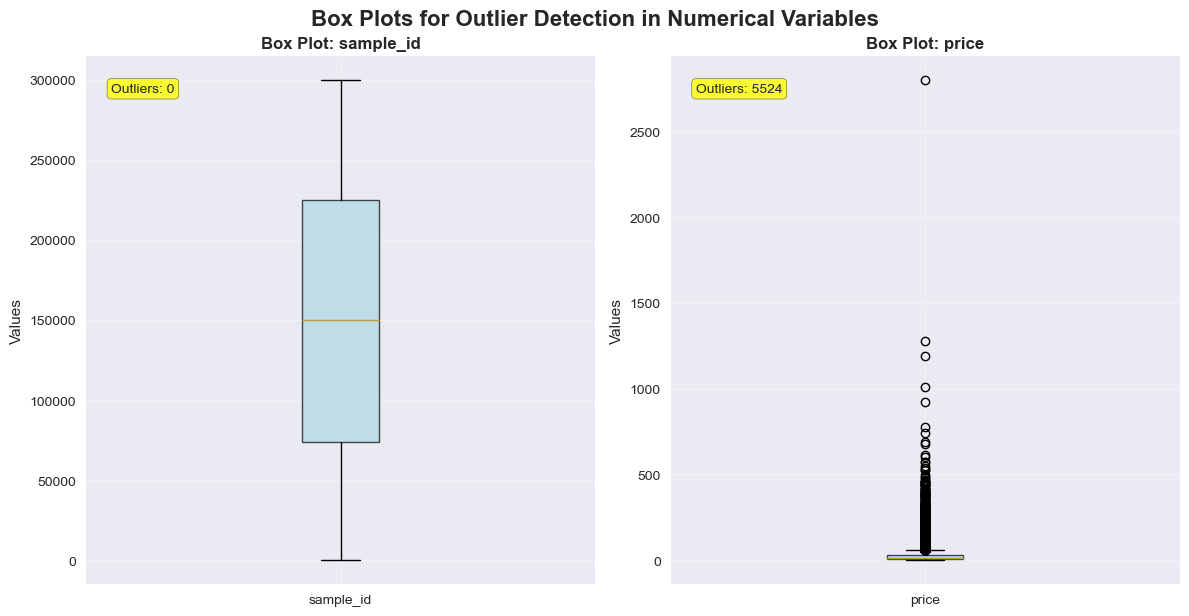


 OUTLIER ANALYSIS:
  sample_id: 0 outliers (0.00%)
  price: 5524 outliers (7.37%)


In [7]:
def create_boxplots_fixed(df, numerical_columns, figsize=(12, 6)):
    """
    Create box plots to identify outliers in numerical variables - FIXED VERSION
    """
    numerical_cols = [col for col in numerical_columns if col in df.columns]
    
    print(f" Creating box plots for: {numerical_cols}")
    
    n_cols = len(numerical_cols)
    fig, axes = plt.subplots(1, n_cols, figsize=figsize)
    
    # If only one column, make axes a list for consistent indexing
    if n_cols == 1:
        axes = [axes]
    
    for idx, col in enumerate(numerical_cols):
        # Create box plot
        box_data = [df[col].dropna()]
        axes[idx].boxplot(box_data, vert=True, patch_artist=True,
                         boxprops=dict(facecolor='lightblue', alpha=0.7))
        axes[idx].set_title(f'Box Plot: {col}', fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Values')
        axes[idx].set_xticklabels([col])
        
        # Add some styling
        axes[idx].grid(True, alpha=0.3)
        
        # Calculate and display outlier information
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        
        axes[idx].text(0.05, 0.95, f'Outliers: {len(outliers)}', 
                      transform=axes[idx].transAxes,
                      bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.8),
                      verticalalignment='top')
    
    plt.tight_layout()
    plt.suptitle('Box Plots for Outlier Detection in Numerical Variables', 
                 y=1.02, fontsize=16, fontweight='bold')
    plt.show()
    
    # Print outlier analysis
    print("\n OUTLIER ANALYSIS:")
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        print(f"  {col}: {len(outliers)} outliers ({len(outliers)/len(df)*100:.2f}%)")

# Create fixed box plots
if df is not None and numerical_columns:
    create_boxplots_fixed(df, numerical_columns)

In [8]:
def analyze_categorical_variables(df, max_categories=10):
    """
    Analyze categorical variables in the dataset
    """
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    
    print(f" CATEGORICAL VARIABLES ANALYSIS")
    print("=" * 40)
    print(f"Found {len(categorical_columns)} categorical variables:")
    
    for col in categorical_columns:
        print(f"\n {col}:")
        value_counts = df[col].value_counts()
        print(f"  Unique values: {df[col].nunique()}")
        print(f"  Missing values: {df[col].isnull().sum()}")
        
        if df[col].nunique() <= max_categories:
            print(f"  Value counts:")
            for value, count in value_counts.head(max_categories).items():
                print(f"    {value}: {count} ({count/len(df)*100:.1f}%)")
        else:
            print(f"  Top {max_categories} values:")
            for value, count in value_counts.head(max_categories).items():
                print(f"    {value}: {count} ({count/len(df)*100:.1f}%)")
            print(f"  ... and {df[col].nunique() - max_categories} more categories")
    
    # Create visualizations for categorical variables with reasonable number of categories
    categorical_to_plot = [col for col in categorical_columns if df[col].nunique() <= 15]
    
    if categorical_to_plot:
        n_cols = min(2, len(categorical_to_plot))
        n_rows = (len(categorical_to_plot) + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        if n_rows == 1:
            axes = [axes] if n_cols == 1 else axes
        
        for idx, col in enumerate(categorical_to_plot):
            if n_rows > 1:
                row = idx // n_cols
                col_idx = idx % n_cols
                ax = axes[row, col_idx]
            else:
                ax = axes[idx] if n_cols > 1 else axes
            
            value_counts = df[col].value_counts().head(10)  # Top 10 only
            bars = ax.bar(range(len(value_counts)), value_counts.values, color='skyblue', alpha=0.7)
            ax.set_title(f'Distribution: {col}', fontweight='bold')
            ax.set_xlabel(col)
            ax.set_ylabel('Count')
            ax.set_xticks(range(len(value_counts)))
            ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
            
            # Add value labels on bars
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}', ha='center', va='bottom')
            
            ax.grid(True, alpha=0.3)
        
        # Hide empty subplots
        for idx in range(len(categorical_to_plot), n_rows * n_cols):
            if n_rows > 1:
                row = idx // n_cols
                col_idx = idx % n_cols
                axes[row, col_idx].set_visible(False)
            else:
                if n_cols > 1:
                    axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.suptitle('Categorical Variables Distribution', y=1.02, fontsize=16, fontweight='bold')
        plt.show()
    
    return categorical_columns

# Analyze categorical variables
if df is not None:
    categorical_columns = analyze_categorical_variables(df)

 CATEGORICAL VARIABLES ANALYSIS
Found 2 categorical variables:

 catalog_content:
  Unique values: 74900
  Missing values: 0
  Top 10 values:
    Item Name: PAPYRUS Everyday Card, 1 EA
Value: 1.0
Unit: Count
: 5 (0.0%)
    Item Name: Eden Foods Salt Gomasio Ssme Seawd
Value: 1.0
Unit: Count
: 3 (0.0%)
    Item Name: PAPYRUS Everyday Card, 1 EA
Product Description: Lifestyle
Value: 1.0
Unit: Count
: 3 (0.0%)
    Item Name: Rose’s Sweetened Grenadine Syrup 25oz Bottle | Perfect for Cocktails, Beverages, and Mixers
Bullet Point 1: Grenadine: A rich, pomegranate flavor, sweetened for perfect mixability in your favorite cocktails and spirits. It's also an ideal addition to non-alcoholic drinks, adding both a vibrant splash of color and delicious flavor.
Bullet Point 2: Trusted for Over a Century: Rose’s has been the go-to brand for premium mixers for more than 100 years, earning the trust of bartenders and cocktail enthusiasts alike.
Bullet Point 3: Exceptional Quality: Renowned for its con

 ENHANCED TARGET VARIABLE ANALYSIS: price
  Count: 75000
  Mean: 23.65
  Median: 14.00
  Std Dev: 33.38
  Min: 0.13
  Max: 2796.00
  Range: 2795.87
  IQR: 21.83
  Skewness: 13.60
  Kurtosis: 736.65
  Missing Values: 0


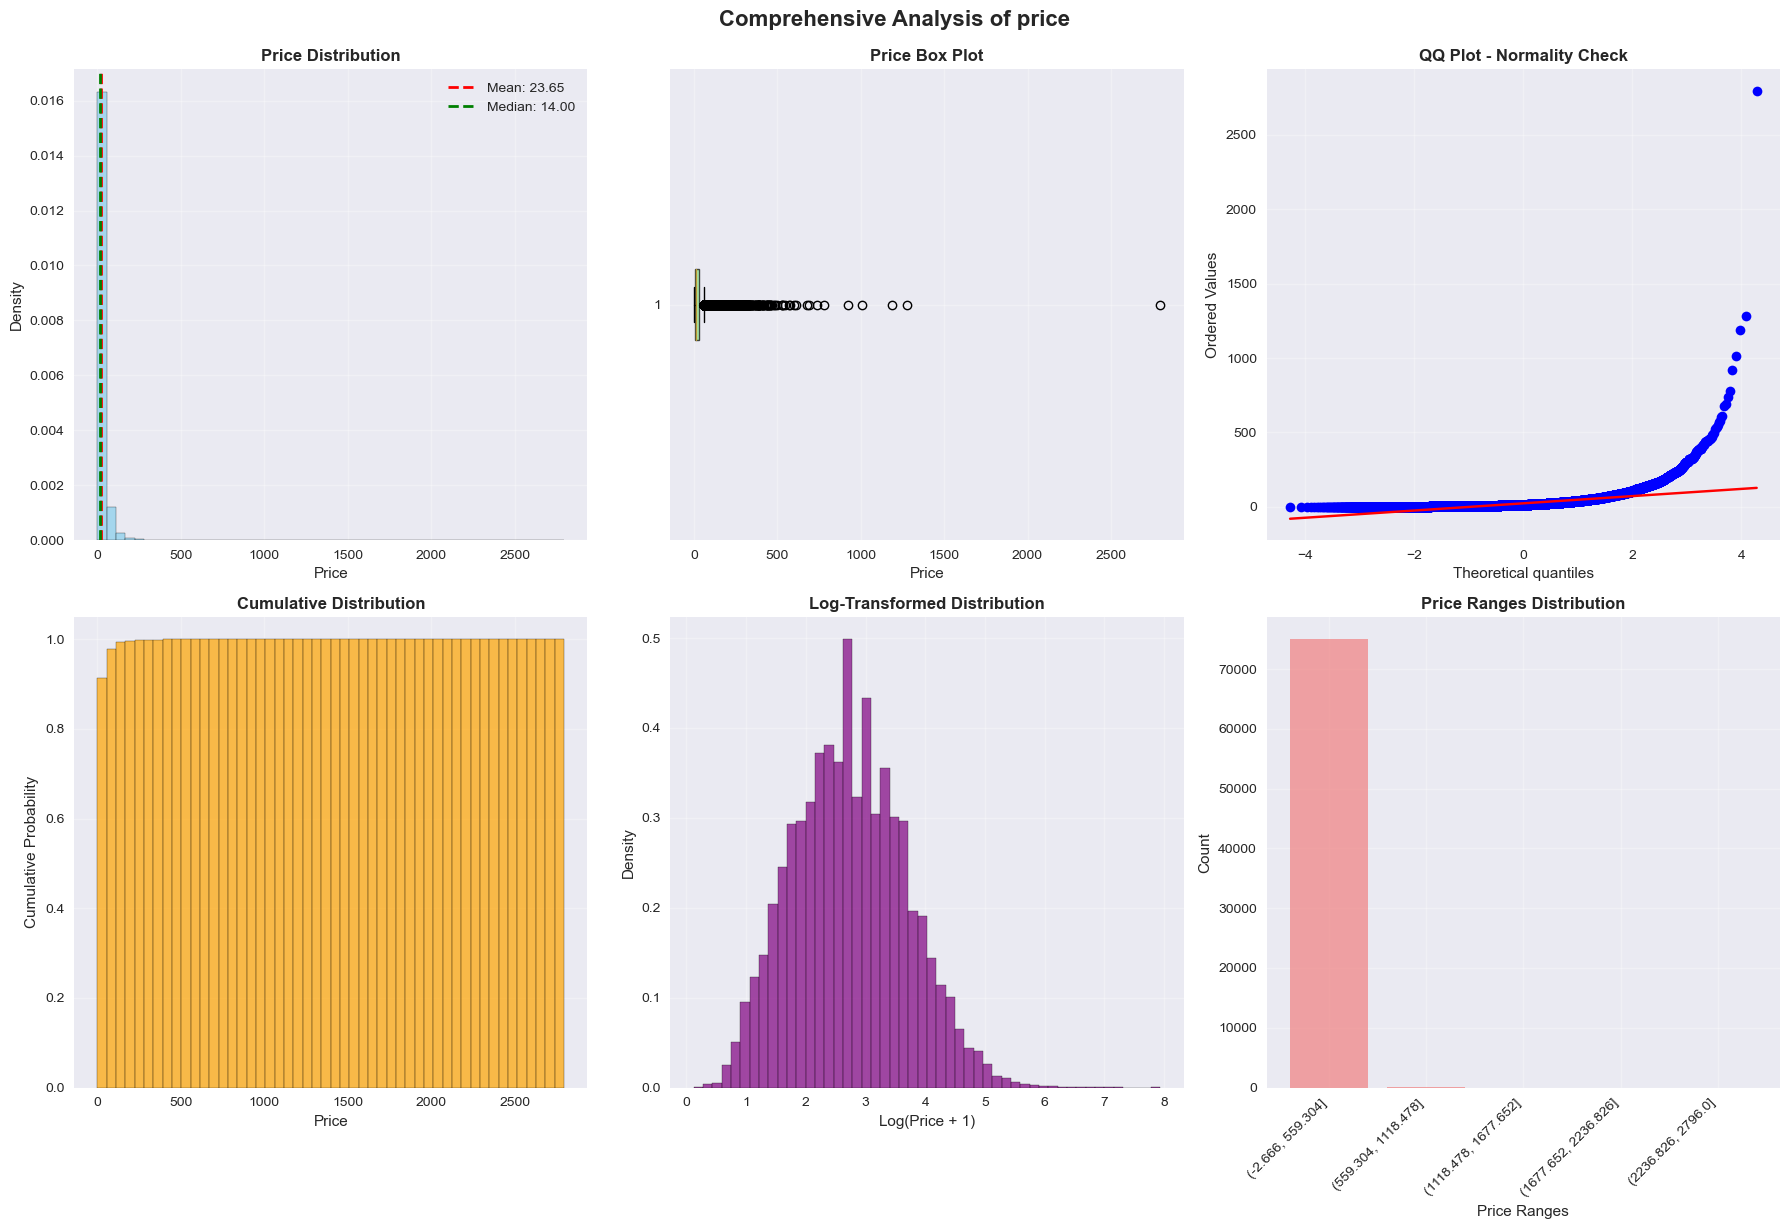


 INTERPRETATION:
• Skewness: 13.60 (|skewness| > 1 indicates high skewness)
• Kurtosis: 736.65 (>3 indicates heavy tails)
• Data is highly right-skewed - consider log transformation for modeling


In [9]:
def enhanced_target_analysis(df, target_column='price'):
    """
    Enhanced analysis specifically for the target variable 'price'
    """
    if target_column not in df.columns:
        print(f" Target column '{target_column}' not found")
        return
    
    print(f" ENHANCED TARGET VARIABLE ANALYSIS: {target_column}")
    print("=" * 50)
    
    target_data = df[target_column].dropna()
    
    # Comprehensive statistics
    stats_dict = {
        'Count': len(target_data),
        'Mean': target_data.mean(),
        'Median': target_data.median(),
        'Std Dev': target_data.std(),
        'Min': target_data.min(),
        'Max': target_data.max(),
        'Range': target_data.max() - target_data.min(),
        'IQR': target_data.quantile(0.75) - target_data.quantile(0.25),
        'Skewness': target_data.skew(),
        'Kurtosis': target_data.kurtosis(),
        'Missing Values': df[target_column].isnull().sum()
    }
    
    for stat, value in stats_dict.items():
        if isinstance(value, float):
            print(f"  {stat}: {value:.2f}")
        else:
            print(f"  {stat}: {value}")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. Distribution histogram
    axes[0, 0].hist(target_data, bins=50, alpha=0.7, color='skyblue', edgecolor='black', density=True)
    axes[0, 0].axvline(target_data.mean(), color='red', linestyle='--', linewidth=2, 
                      label=f'Mean: {target_data.mean():.2f}')
    axes[0, 0].axvline(target_data.median(), color='green', linestyle='--', linewidth=2, 
                      label=f'Median: {target_data.median():.2f}')
    axes[0, 0].set_xlabel('Price')
    axes[0, 0].set_ylabel('Density')
    axes[0, 0].set_title('Price Distribution', fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Box plot
    axes[0, 1].boxplot(target_data, vert=False, patch_artist=True,
                      boxprops=dict(facecolor='lightgreen', alpha=0.7))
    axes[0, 1].set_xlabel('Price')
    axes[0, 1].set_title('Price Box Plot', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. QQ Plot
    stats.probplot(target_data, dist="norm", plot=axes[0, 2])
    axes[0, 2].set_title('QQ Plot - Normality Check', fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Cumulative distribution
    axes[1, 0].hist(target_data, bins=50, alpha=0.7, color='orange', 
                   cumulative=True, density=True, edgecolor='black')
    axes[1, 0].set_xlabel('Price')
    axes[1, 0].set_ylabel('Cumulative Probability')
    axes[1, 0].set_title('Cumulative Distribution', fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Log transformation (if needed for skewed data)
    if target_data.skew() > 1:  # If highly skewed
        log_data = np.log1p(target_data)  # log(1+x) to handle zeros
        axes[1, 1].hist(log_data, bins=50, alpha=0.7, color='purple', edgecolor='black', density=True)
        axes[1, 1].set_xlabel('Log(Price + 1)')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].set_title('Log-Transformed Distribution', fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # If not skewed, show density plot
        target_data.plot.density(ax=axes[1, 1], color='red', linewidth=2)
        axes[1, 1].set_xlabel('Price')
        axes[1, 1].set_ylabel('Density')
        axes[1, 1].set_title('Density Plot', fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
    
    # 6. Price ranges analysis
    price_ranges = pd.cut(target_data, bins=5)
    range_counts = price_ranges.value_counts().sort_index()
    axes[1, 2].bar(range(len(range_counts)), range_counts.values, color='lightcoral', alpha=0.7)
    axes[1, 2].set_xlabel('Price Ranges')
    axes[1, 2].set_ylabel('Count')
    axes[1, 2].set_title('Price Ranges Distribution', fontweight='bold')
    axes[1, 2].set_xticks(range(len(range_counts)))
    axes[1, 2].set_xticklabels([str(x) for x in range_counts.index], rotation=45, ha='right')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle(f'Comprehensive Analysis of {target_column}', y=1.02, fontsize=16, fontweight='bold')
    plt.show()
    
    # Interpretation
    print(f"\n INTERPRETATION:")
    print(f"• Skewness: {target_data.skew():.2f} (|skewness| > 1 indicates high skewness)")
    print(f"• Kurtosis: {target_data.kurtosis():.2f} (>3 indicates heavy tails)")
    if target_data.skew() > 1:
        print("• Data is highly right-skewed - consider log transformation for modeling")
    elif target_data.skew() < -1:
        print("• Data is highly left-skewed - consider transformation for modeling")
    else:
        print("• Data is approximately symmetric")

# Run enhanced target analysis
if df is not None:
    enhanced_target_analysis(df, 'price')

# Correlation Analysis

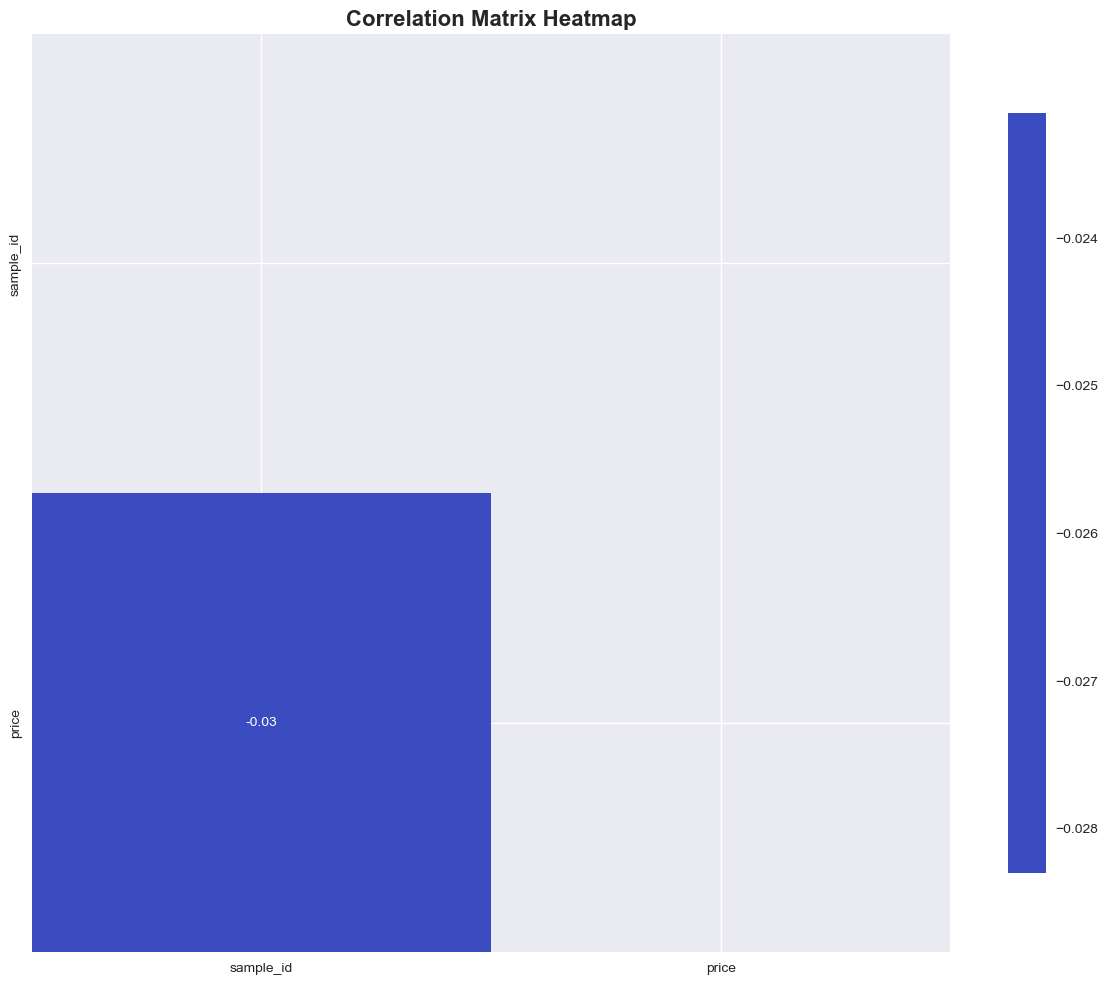

Correlations with price:
  sample_id: -0.026


In [10]:
def analyze_correlations(df, numerical_columns, target_column='price'):
    """
    Analyze correlations between numerical variables and target
    """
    numerical_cols = [col for col in numerical_columns if col in df.columns]
    
    if target_column not in numerical_cols and target_column in df.columns:
        numerical_cols.append(target_column)
    
    # Calculating the correlation matrix
    corr_matrix = df[numerical_cols].corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Show correlations with target variable
    if target_column in corr_matrix.columns:
        target_correlations = corr_matrix[target_column].sort_values(ascending=False)
        print(f"Correlations with {target_column}:")
        for feature, corr in target_correlations.items():
            if feature != target_column:
                print(f"  {feature}: {corr:.3f}")

# Perform correlation analysis
if df is not None and numerical_columns:
    analyze_correlations(df, numerical_columns)

# Data Preprocessing Function

In [11]:
def preprocess_data(df, target_column='price'):
    """
    Preprocess the data for modeling
    """
    print("DATA PREPROCESSING")
    print("=" * 40)
    
    # STEP 1: Extract text features FIRST
    df_processed = extract_text_features(df)
    
    # STEP 2: Handle missing values
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    
    # For numerical columns - fill with median
    for col in numerical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
            print(f"Filled missing values in {col} with median")
    
    # For categorical columns - fill with mode
    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0] if not df_processed[col].mode().empty else 'Unknown', inplace=True)
            print(f"Filled missing values in {col} with mode")
    
    # STEP 3: Remove duplicates
    initial_rows = len(df_processed)
    df_processed = df_processed.drop_duplicates()
    final_rows = len(df_processed)
    print(f"Removed {initial_rows - final_rows} duplicate rows")
    
    # STEP 4: Encode categorical variables (EXCLUDE catalog_content - it's already processed)
    label_encoders = {}
    for col in categorical_cols:
        if col != target_column and col != 'catalog_content':  # Skip the heavy text column
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
            label_encoders[col] = le
            print(f"Encoded categorical variable: {col}")
    
    # STEP 5: Drop the original heavy text column to save memory
    if 'catalog_content' in df_processed.columns:
        df_processed = df_processed.drop('catalog_content', axis=1)
        print("Dropped original catalog_content column")
    
    print(f"Final processed dataset shape: {df_processed.shape}")
    print("Preprocessing completed!")
    return df_processed, label_encoders

# Test the preprocessing function
if df is not None:
    df_processed, label_encoders = preprocess_data(df)
    print(f"\nProcessed data shape: {df_processed.shape}")
    print(f"Processed data columns: {df_processed.columns.tolist()}")

DATA PREPROCESSING
EXTRACTING TEXT FEATURES FROM CATALOG_CONTENT
  Created feature: has_meat
  Created feature: has_cheese
  Created feature: has_snack
  Created feature: has_beverage
  Created feature: has_spice
  Created feature: has_organic
  Created feature: has_gluten_free
  Created feature: has_vegan
  Created feature: has_kosher
Added 14 text-based features
Removed 0 duplicate rows
Encoded categorical variable: image_link
Dropped original catalog_content column
Final processed dataset shape: (75000, 17)
Preprocessing completed!

Processed data shape: (75000, 17)
Processed data columns: ['sample_id', 'image_link', 'price', 'text_length', 'word_count', 'has_meat', 'has_cheese', 'has_snack', 'has_beverage', 'has_spice', 'has_organic', 'has_gluten_free', 'has_vegan', 'has_kosher', 'has_premium', 'has_bulk', 'has_small']


# Prepare Features and Target

In [12]:
def prepare_features_target(df_processed, target_column='price'):
    """
    Prepare features (X) and target (y) for modeling
    """
    # Remove target from features
    X = df_processed.drop(columns=[target_column])
    y = df_processed[target_column]
    
    print("FEATURE AND TARGET PREPARATION")
    print("=" * 45)
    print(f"Features shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Feature columns: {list(X.columns)}")
    
    return X, y

# Prepare data for modeling
if 'df_processed' in locals():
    X, y = prepare_features_target(df_processed)

FEATURE AND TARGET PREPARATION
Features shape: (75000, 16)
Target shape: (75000,)
Feature columns: ['sample_id', 'image_link', 'text_length', 'word_count', 'has_meat', 'has_cheese', 'has_snack', 'has_beverage', 'has_spice', 'has_organic', 'has_gluten_free', 'has_vegan', 'has_kosher', 'has_premium', 'has_bulk', 'has_small']


# Train-Test Split and Basic Model

TRAINING BASELINE MODEL
Training set: (60000, 16)
Testing set: (15000, 16)
Training model...
MODEL PERFORMANCE:
  MAE (Mean Absolute Error): 17.2640
  RMSE (Root Mean Squared Error): 36.5550
  R² Score: 0.1146

TOP 10 FEATURE IMPORTANCES:
         feature  importance
0      sample_id    0.299805
1     image_link    0.254022
2    text_length    0.192197
3     word_count    0.125249
7   has_beverage    0.016384
9    has_organic    0.015467
6      has_snack    0.015068
12    has_kosher    0.012513
13   has_premium    0.011929
4       has_meat    0.010261


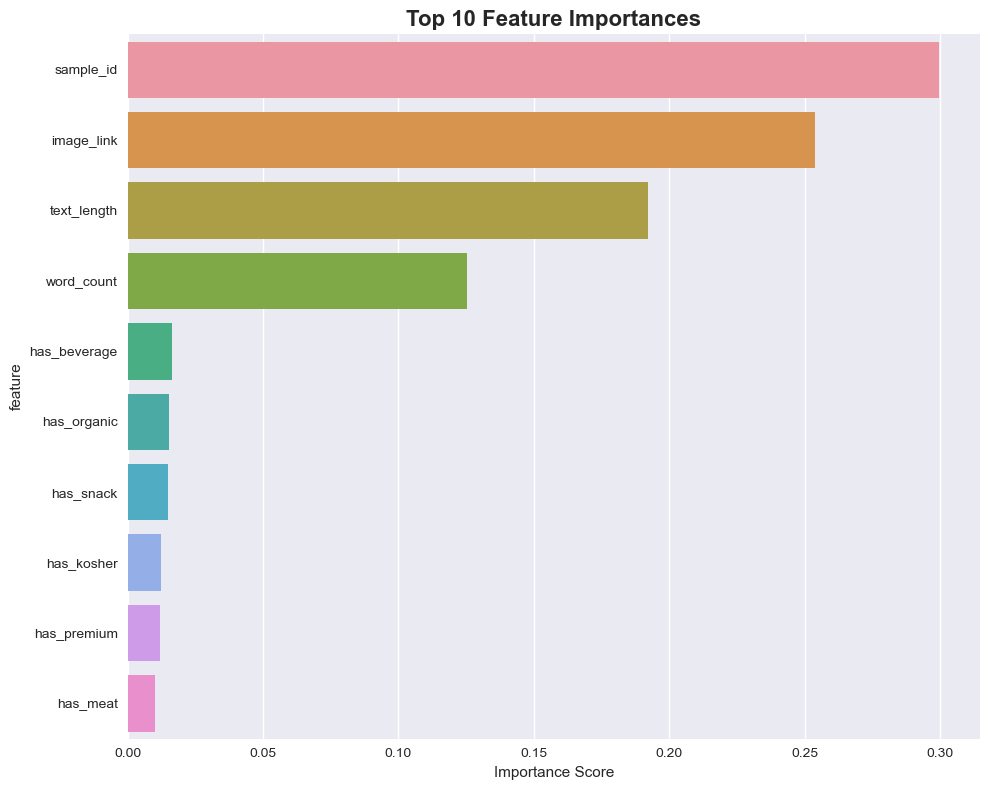

In [13]:
def train_baseline_model(X, y, test_size=0.2, random_state=42):
    """
    Train a baseline Random Forest model
    """
    print("TRAINING BASELINE MODEL")
    print("=" * 35)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Testing set: {X_test.shape}")
    
    # Initialize and train model
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=random_state,
        n_jobs=-1
    )
    
    print("Training model...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("MODEL PERFORMANCE:")
    print(f"  MAE (Mean Absolute Error): {mae:.4f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTOP 10 FEATURE IMPORTANCES:")
    print(feature_importance.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(10)
    sns.barplot(data=top_features, x='importance', y='feature')
    plt.title('Top 10 Feature Importances', fontsize=16, fontweight='bold')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()
    
    return model, X_test, y_test, y_pred

# Train baseline model
if 'X' in locals() and 'y' in locals():
    model, X_test, y_test, y_pred = train_baseline_model(X, y)

# Model Evaluation and Residual Analysis

 RESIDUAL ANALYSIS
Residual Mean: -1.1998
Residual Std: 36.5365


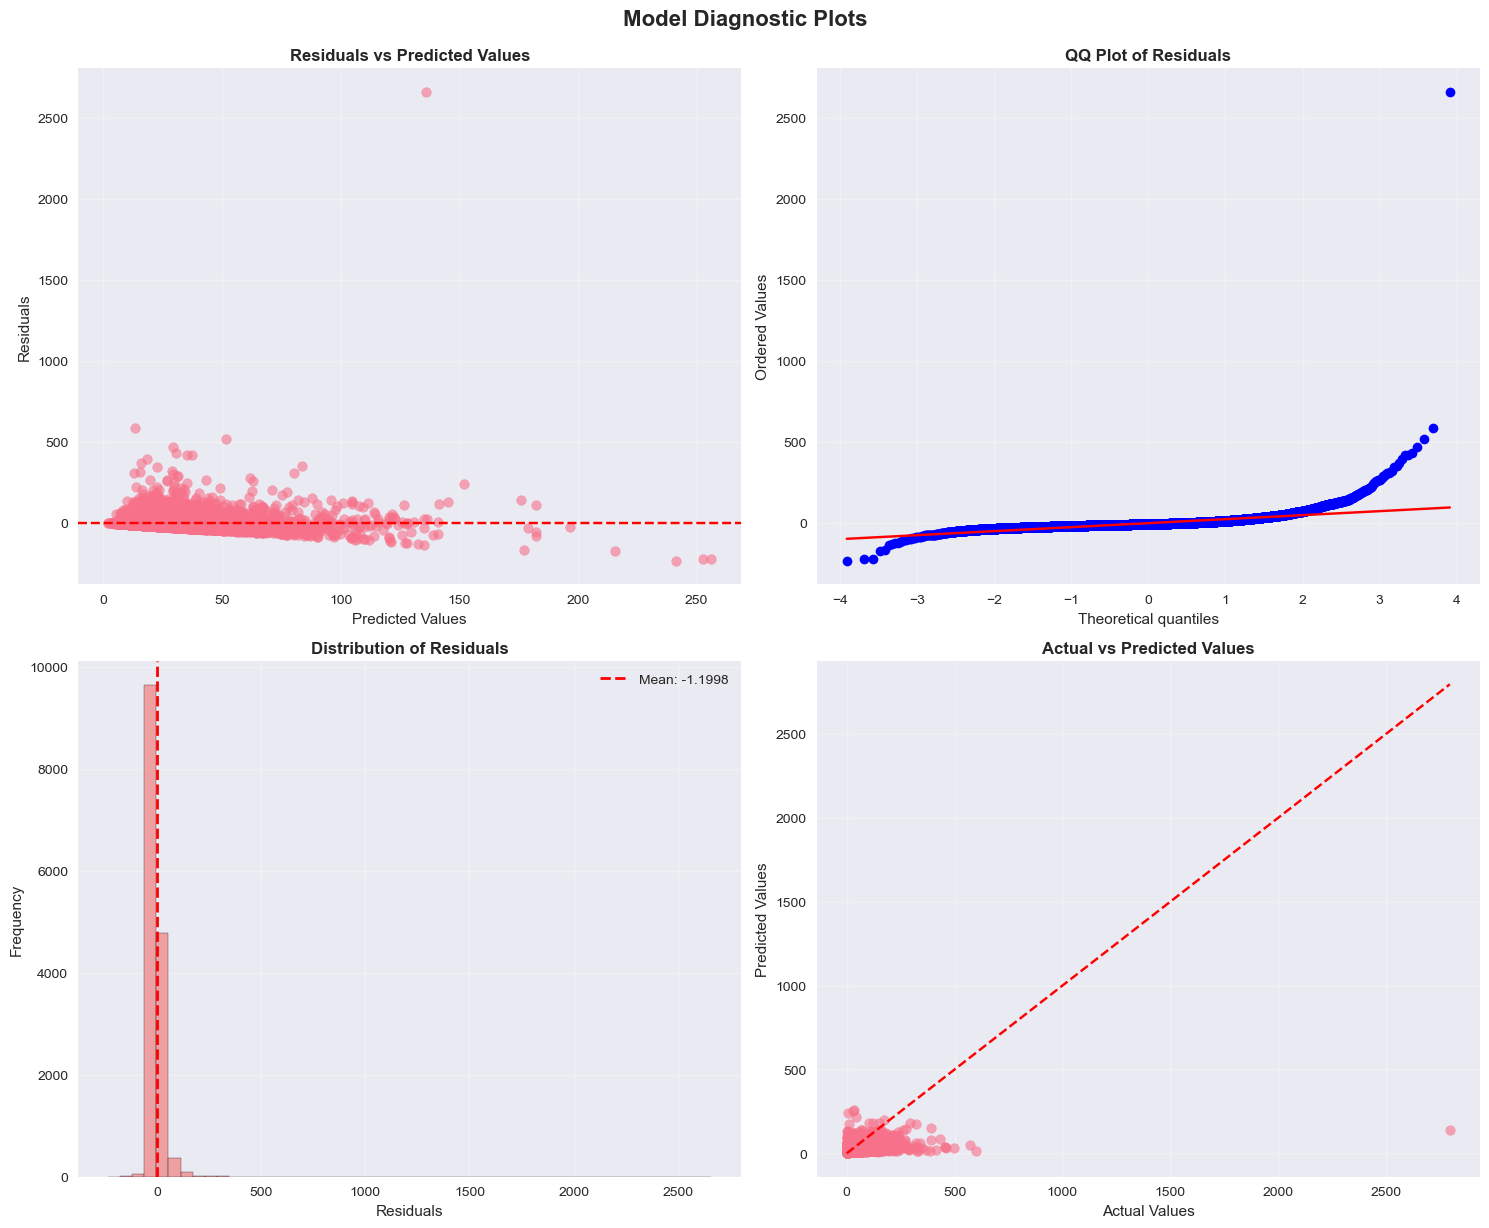

In [14]:
def analyze_residuals(y_test, y_pred):
    """
    Analyze model residuals and create diagnostic plots
    """
    residuals = y_test - y_pred
    
    print(" RESIDUAL ANALYSIS")
    print("=" * 25)
    print(f"Residual Mean: {residuals.mean():.4f}")
    print(f"Residual Std: {residuals.std():.4f}")
    
    # Create residual plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Residuals vs Predicted
    axes[0, 0].scatter(y_pred, residuals, alpha=0.6)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Predicted Values', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. QQ Plot of residuals
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('QQ Plot of Residuals', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Distribution of residuals
    axes[1, 0].hist(residuals, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1, 0].axvline(residuals.mean(), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {residuals.mean():.4f}')
    axes[1, 0].set_xlabel('Residuals')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Residuals', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Actual vs Predicted
    axes[1, 1].scatter(y_test, y_pred, alpha=0.6)
    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--')
    axes[1, 1].set_xlabel('Actual Values')
    axes[1, 1].set_ylabel('Predicted Values')
    axes[1, 1].set_title('Actual vs Predicted Values', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Model Diagnostic Plots', y=1.02, fontsize=16, fontweight='bold')
    plt.show()

# Analyze residuals
if 'y_test' in locals() and 'y_pred' in locals():
    analyze_residuals(y_test, y_pred)

COMPREHENSIVE MODEL EVALUATION
PERFORMANCE COMPARISON:
Metric          Training     Test         Difference  
-------------------------------------------------------
MAE             8.4571       17.2640      -8.8069     
RMSE            19.1747      36.5550      -17.3803    
R² Score        0.6700       0.1146       0.5554      
MAPE %          90.91        186.83       -95.92      
Explained Var   0.6704       0.1155       0.5548      

OVERFITTING ANALYSIS:
  Potential overfitting: Large R² difference (0.5554)

FEATURE IMPORTANCE SUMMARY:
Total features: 16
Top 5 features account for 88.8% of importance
Bottom 10 features account for 9.7% of importance


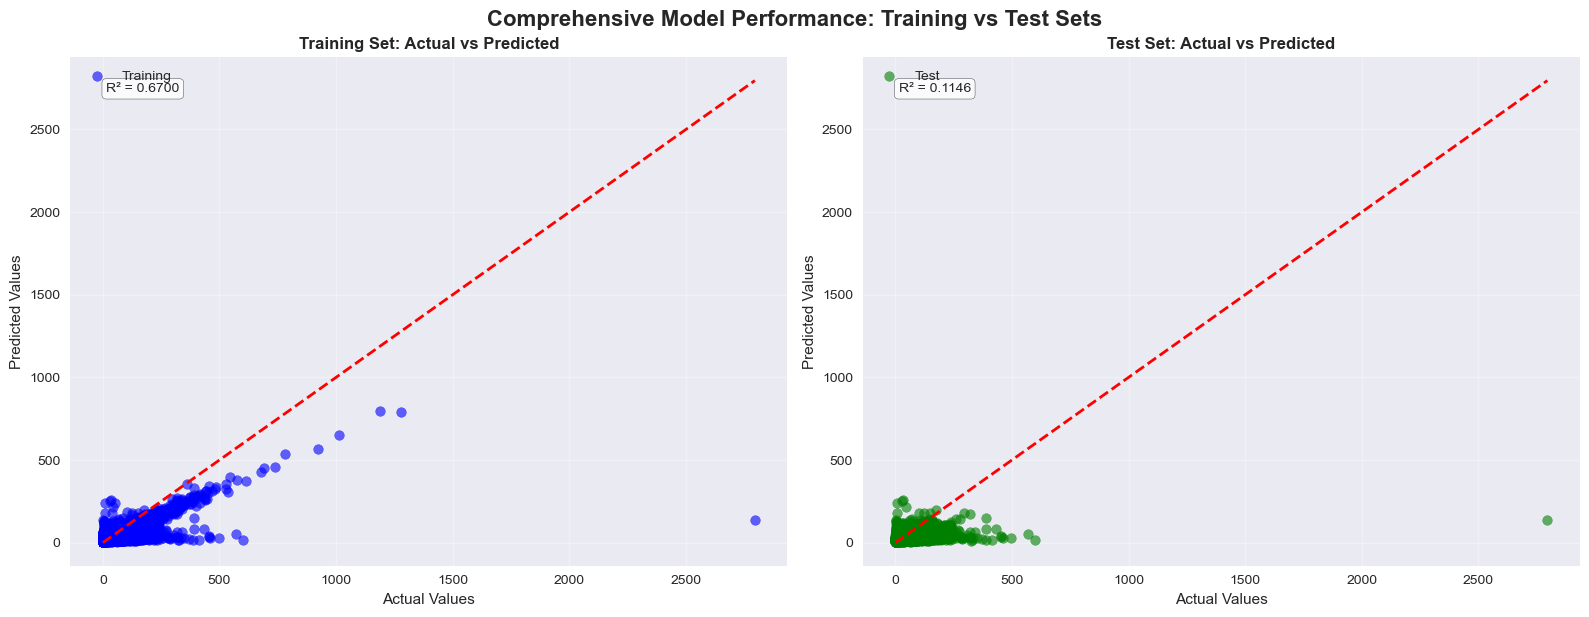


MODEL INTERPRETATION AND RECOMMENDATIONS

 PERFORMANCE INTERPRETATION:
VERY POOR: Model explains <30% of variance

 OVERFITTING ASSESSMENT:
 STRONG OVERFITTING: Large gap between training and test performance
   Recommendations: Regularization, Reduce model complexity, Cross-validation

 FEATURE RECOMMENDATIONS:
Top 3 most important features:
  1. sample_id (importance: 0.2998)
  2. image_link (importance: 0.2540)
  3. text_length (importance: 0.1922)

Consider removing 5 features with importance < 0.01
Low importance features: ['has_gluten_free', 'has_spice', 'has_small', 'has_vegan', 'has_bulk']

 FINAL MODEL SUMMARY:
Training R²: 0.6700
Test R²: 0.1146
Generalization Gap: 0.5554
Model effectively explains 11.5% of variance in test data


In [15]:
def evaluate_training_performance(model, X, y, X_test, y_test, y_pred):
    """
    Evaluate model performance on both training and test sets
    """
    print("COMPREHENSIVE MODEL EVALUATION")
    print("=" * 45)
    
    # Training set predictions and metrics
    y_train_pred = model.predict(X)
    
    # Test set metrics (already calculated)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    
    # Training set metrics
    train_mae = mean_absolute_error(y, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y, y_train_pred))
    train_r2 = r2_score(y, y_train_pred)
    
    print("PERFORMANCE COMPARISON:")
    print(f"{'Metric':<15} {'Training':<12} {'Test':<12} {'Difference':<12}")
    print("-" * 55)
    print(f"{'MAE':<15} {train_mae:<12.4f} {test_mae:<12.4f} {train_mae-test_mae:<12.4f}")
    print(f"{'RMSE':<15} {train_rmse:<12.4f} {test_rmse:<12.4f} {train_rmse-test_rmse:<12.4f}")
    print(f"{'R² Score':<15} {train_r2:<12.4f} {test_r2:<12.4f} {train_r2-test_r2:<12.4f}")
    
    # Calculate additional metrics
    from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score
    
    # MAPE (Mean Absolute Percentage Error)
    try:
        test_mape = mean_absolute_percentage_error(y_test, y_pred) * 100
        train_mape = mean_absolute_percentage_error(y, y_train_pred) * 100
        print(f"{'MAPE %':<15} {train_mape:<12.2f} {test_mape:<12.2f} {train_mape-test_mape:<12.2f}")
    except:
        print("MAPE could not be calculated (possibly zero values in target)")
    
    # Explained Variance Score
    test_evs = explained_variance_score(y_test, y_pred)
    train_evs = explained_variance_score(y, y_train_pred)
    print(f"{'Explained Var':<15} {train_evs:<12.4f} {test_evs:<12.4f} {train_evs-test_evs:<12.4f}")
    
    # Overfitting analysis
    print(f"\nOVERFITTING ANALYSIS:")
    r2_diff = train_r2 - test_r2
    if r2_diff > 0.1:
        print(f"  Potential overfitting: Large R² difference ({r2_diff:.4f})")
    elif r2_diff > 0.05:
        print(f"  Moderate difference: R² difference ({r2_diff:.4f})")
    else:
        print(f" Good generalization: Small R² difference ({r2_diff:.4f})")
    
    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nFEATURE IMPORTANCE SUMMARY:")
    print(f"Total features: {len(feature_importance)}")
    print(f"Top 5 features account for {feature_importance.head(5)['importance'].sum()*100:.1f}% of importance")
    print(f"Bottom 10 features account for {feature_importance.tail(10)['importance'].sum()*100:.1f}% of importance")
    
    return y_train_pred, train_r2, test_r2

def plot_actual_vs_predicted_comprehensive(y_train, y_train_pred, y_test, y_pred):
    """
    Create comprehensive actual vs predicted plots for both training and test sets
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Training set
    axes[0].scatter(y_train, y_train_pred, alpha=0.6, color='blue', label='Training')
    max_val = max(y_train.max(), y_train_pred.max())
    min_val = min(y_train.min(), y_train_pred.min())
    axes[0].plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Actual Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title('Training Set: Actual vs Predicted', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    # Add R² to plot
    train_r2 = r2_score(y_train, y_train_pred)
    axes[0].text(0.05, 0.95, f'R² = {train_r2:.4f}', transform=axes[0].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                verticalalignment='top')
    
    # Test set
    axes[1].scatter(y_test, y_pred, alpha=0.6, color='green', label='Test')
    max_val = max(y_test.max(), y_pred.max())
    min_val = min(y_test.min(), y_pred.min())
    axes[1].plot([min_val, max_val], [min_val, max_val], 'red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Actual Values')
    axes[1].set_ylabel('Predicted Values')
    axes[1].set_title('Test Set: Actual vs Predicted', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    # Add R² to plot
    test_r2 = r2_score(y_test, y_pred)
    axes[1].text(0.05, 0.95, f'R² = {test_r2:.4f}', transform=axes[1].transAxes,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
                verticalalignment='top')
    
    plt.tight_layout()
    plt.suptitle('Comprehensive Model Performance: Training vs Test Sets', 
                 y=1.02, fontsize=16, fontweight='bold')
    plt.show()

def model_interpretation_report(model, X, y_train_pred, train_r2, test_r2):
    """
    Provide interpretation and recommendations based on model performance
    """
    print("\n" + "="*60)
    print("MODEL INTERPRETATION AND RECOMMENDATIONS")
    print("="*60)
    
    # Model performance interpretation
    print("\n PERFORMANCE INTERPRETATION:")
    if test_r2 >= 0.9:
        print("EXCELLENT: Model explains >90% of variance")
    elif test_r2 >= 0.7:
        print("GOOD: Model explains >70% of variance")
    elif test_r2 >= 0.5:
        print("FAIR: Model explains >50% of variance")
    elif test_r2 >= 0.3:
        print("  POOR: Model explains only 30-50% of variance")
    else:
        print("VERY POOR: Model explains <30% of variance")
    
    # Overfitting assessment
    r2_diff = train_r2 - test_r2
    print(f"\n OVERFITTING ASSESSMENT:")
    if r2_diff > 0.15:
        print(" STRONG OVERFITTING: Large gap between training and test performance")
        print("   Recommendations: Regularization, Reduce model complexity, Cross-validation")
    elif r2_diff > 0.08:
        print("  MODERATE OVERFITTING: Noticeable performance gap")
        print("   Recommendations: Tune hyperparameters, Feature selection")
    else:
        print(" GOOD GENERALIZATION: Model performs similarly on training and test data")
    
    # Feature recommendations
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n FEATURE RECOMMENDATIONS:")
    print(f"Top 3 most important features:")
    for i, (_, row) in enumerate(feature_importance.head(3).iterrows(), 1):
        print(f"  {i}. {row['feature']} (importance: {row['importance']:.4f})")
    
    low_importance_features = feature_importance[feature_importance['importance'] < 0.01]
    if len(low_importance_features) > 0:
        print(f"\nConsider removing {len(low_importance_features)} features with importance < 0.01")
        print("Low importance features:", list(low_importance_features['feature']))

# Run comprehensive evaluation
if 'model' in locals() and 'X' in locals() and 'y_test' in locals() and 'y_pred' in locals():
    # Get training predictions
    y_train_pred, train_r2, test_r2 = evaluate_training_performance(model, X, y, X_test, y_test, y_pred)
    
    # Plot comprehensive comparison
    plot_actual_vs_predicted_comprehensive(y, y_train_pred, y_test, y_pred)
    
    # Provide interpretation
    model_interpretation_report(model, X, y_train_pred, train_r2, test_r2)
    
    # Final summary
    print(f"\n FINAL MODEL SUMMARY:")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Generalization Gap: {train_r2 - test_r2:.4f}")
    print(f"Model effectively explains {test_r2*100:.1f}% of variance in test data")
else:
    print("Model evaluation cannot be performed - required variables not found")

In [16]:
def fix_overfitting_and_improve_model(X, y):
    """
    Fix the severe overfitting and improve price prediction
    """
    print(" IMPLEMENTING OVERFITTING FIXES...")
    print("=" * 50)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Solution 1: Use simpler, regularized model
    from sklearn.linear_model import Ridge
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    
    models = {
        'Ridge (Regularized)': Ridge(alpha=10.0),
        'Decision Tree (Pruned)': DecisionTreeRegressor(max_depth=10, min_samples_split=20, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
        'Random Forest (Tuned)': RandomForestRegressor(
            n_estimators=50,
            max_depth=10,
            min_samples_split=20,
            min_samples_leaf=10,
            random_state=42
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        
        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # Metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        r2_gap = train_r2 - test_r2
        
        results[name] = {
            'train_r2': train_r2,
            'test_r2': test_r2,
            'r2_gap': r2_gap,
            'model': model
        }
        
        print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}, Gap: {r2_gap:.4f}")
    
    # Find best model
    best_model_name = max(results.keys(), key=lambda x: results[x]['test_r2'])
    best_model = results[best_model_name]['model']
    
    print(f"\n BEST MODEL: {best_model_name}")
    print(f"   Test R²: {results[best_model_name]['test_r2']:.4f}")
    
    return best_model, results

def feature_selection_analysis(X, y):
    """
    Analyze and select most important features to reduce overfitting
    """
    print("\n PERFORMING FEATURE SELECTION...")
    
    # Use simpler model for feature importance
    from sklearn.linear_model import Lasso
    
    lasso = Lasso(alpha=0.1, random_state=42)
    lasso.fit(X, y)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': np.abs(lasso.coef_)
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"  {i}. {row['feature']}: {row['importance']:.4f}")
    
    # Select top features (remove near-zero importance features)
    important_features = feature_importance[feature_importance['importance'] > 0.01]['feature']
    print(f"\nSelected {len(important_features)} important features (importance > 0.01)")
    
    return important_features

def cross_validation_evaluation(X, y):
    """
    Use cross-validation for more reliable performance estimate
    """
    from sklearn.model_selection import cross_val_score
    
    print("\n CROSS-VALIDATION PERFORMANCE:")
    
    model = RandomForestRegressor(
        n_estimators=50,
        max_depth=10,
        min_samples_split=20,
        random_state=42
    )
    
    # 5-fold cross validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    return cv_scores.mean()

# Apply fixes
if 'X' in locals() and 'y' in locals():
    print("CURRENT MODEL HAS SEVERE OVERFITTING - APPLYING FIXES...")
    
    # 1. Feature selection
    important_features = feature_selection_analysis(X, y)
    X_selected = X[important_features]
    
    # 2. Cross-validation
    cv_score = cross_validation_evaluation(X_selected, y)
    
    # 3. Try multiple models with regularization
    best_model, all_results = fix_overfitting_and_improve_model(X_selected, y)
    
    # 4. Compare all models
    print("\n" + "="*60)
    print("MODEL COMPARISON SUMMARY")
    print("="*60)
    for name, result in all_results.items():
        status = "GOOD" if result['r2_gap'] < 0.1 else "OVERFITTING" if result['r2_gap'] < 0.2 else "SEVERE OVERFITTING"
        print(f"{name:<25} | Test R²: {result['test_r2']:.4f} | Gap: {result['r2_gap']:.4f} | {status}")

CURRENT MODEL HAS SEVERE OVERFITTING - APPLYING FIXES...

 PERFORMING FEATURE SELECTION...
Top 10 Most Important Features:
  1. has_gluten_free: 4.7559
  2. has_premium: 4.4190
  3. has_spice: 3.2621
  4. has_meat: 2.3894
  5. has_snack: 1.4479
  6. has_small: 1.1393
  7. has_beverage: 0.7750
  8. has_organic: 0.7114
  9. has_cheese: 0.4652
  10. has_kosher: 0.1925

Selected 12 important features (importance > 0.01)

 CROSS-VALIDATION PERFORMANCE:
Cross-validation R² scores: [0.05186785 0.06693004 0.06096097 0.06192882 0.05992555]
Mean CV R²: 0.0603 (+/- 0.0097)
 IMPLEMENTING OVERFITTING FIXES...

Training Ridge (Regularized)...
  Train R²: 0.0378, Test R²: 0.0284, Gap: 0.0095

Training Decision Tree (Pruned)...
  Train R²: 0.1291, Test R²: 0.0205, Gap: 0.1087

Training Gradient Boosting...
  Train R²: 0.1504, Test R²: 0.0484, Gap: 0.1020

Training Random Forest (Tuned)...
  Train R²: 0.1240, Test R²: 0.0566, Gap: 0.0674

 BEST MODEL: Random Forest (Tuned)
   Test R²: 0.0566

MODEL COM

In [17]:
def enhanced_feature_engineering(df):
    """
    Create more powerful features for price prediction
    """
    print(" ENHANCED FEATURE ENGINEERING")
    print("=" * 45)
    
    df_enhanced = df.copy()
    
    # 1. Advanced Text Analysis
    if 'catalog_content' in df.columns:
        # Extract numerical values from text (prices, weights, quantities)
        df_enhanced['extracted_price'] = df_enhanced['catalog_content'].str.extract(r'(\$?(\d+\.?\d*))')[1].astype(float).fillna(0)
        df_enhanced['weight_grams'] = df_enhanced['catalog_content'].str.extract(r'(\d+)\s*g').fillna(0).astype(float)
        df_enhanced['volume_ml'] = df_enhanced['catalog_content'].str.extract(r'(\d+)\s*ml').fillna(0).astype(float)
        df_enhanced['quantity_count'] = df_enhanced['catalog_content'].str.extract(r'(\d+)\s*pack').fillna(1).astype(float)
        
        # Text sentiment/complexity
        df_enhanced['description_length'] = df_enhanced['catalog_content'].str.len().fillna(0)
        df_enhanced['word_count'] = df_enhanced['catalog_content'].str.split().str.len().fillna(0)
        df_enhanced['avg_word_length'] = df_enhanced['catalog_content'].apply(
            lambda x: np.mean([len(word) for word in str(x).split()]) if str(x) != 'nan' else 0
        )
    
    # 2. Brand/Quality Indicators
    premium_keywords = ['premium', 'gourmet', 'artisanal', 'organic', 'imported', 'craft']
    for keyword in premium_keywords:
        df_enhanced[f'has_{keyword}'] = df_enhanced['catalog_content'].str.contains(
            keyword, case=False, na=False
        ).astype(int)
    
    # 3. Product Type Clustering
    product_types = {
        'meat_products': ['beef', 'chicken', 'pork', 'lamb', 'meat'],
        'dairy_products': ['cheese', 'milk', 'yogurt', 'butter', 'cream'],
        'beverages': ['juice', 'soda', 'water', 'coffee', 'tea'],
        'snacks': ['chips', 'candy', 'chocolate', 'cookies', 'snack']
    }
    
    for ptype, keywords in product_types.items():
        df_enhanced[ptype] = df_enhanced['catalog_content'].str.contains(
            '|'.join(keywords), case=False, na=False
        ).astype(int)
    
    print(f"Created {len([col for col in df_enhanced.columns if col not in df.columns])} new features")
    return df_enhanced

def create_interaction_features(df):
    """
    Create interaction terms between important features
    """
    print("\n CREATING INTERACTION FEATURES")
    
    # Premium + organic interactions
    if 'has_premium' in df.columns and 'has_organic' in df.columns:
        df['premium_organic'] = df['has_premium'] * df['has_organic']
    
    # Size * premium interactions
    if 'has_premium' in df.columns and 'has_bulk' in df.columns:
        df['premium_bulk'] = df['has_premium'] * df['has_bulk']
    
    # Special diet combinations
    if 'has_gluten_free' in df.columns and 'has_vegan' in df.columns:
        df['gluten_free_vegan'] = df['has_gluten_free'] * df['has_vegan']
    
    return df

def advanced_price_prediction_pipeline(df):
    """
    Complete pipeline for price prediction
    """
    print(" ADVANCED PRICE PREDICTION PIPELINE")
    print("=" * 50)
    
    # Step 1: Enhanced feature engineering
    df_enhanced = enhanced_feature_engineering(df)
    
    # Step 2: Interaction features
    df_enhanced = create_interaction_features(df_enhanced)
    
    # Step 3: Preprocess
    df_processed, _ = preprocess_data(df_enhanced)
    
    # Step 4: Prepare features
    X, y = prepare_features_target(df_processed)
    
    print(f"Final feature set: {X.shape[1]} features")
    print(f"Feature names: {list(X.columns)}")
    
    return X, y

# Trying advanced feature engineering
if df is not None:
    X_advanced, y_advanced = advanced_price_prediction_pipeline(df)
    
    # Test with best model
    from sklearn.ensemble import RandomForestRegressor
    
    model_advanced = RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        random_state=42
    )
    
    # Cross-validation with new features
    from sklearn.model_selection import cross_val_score
    cv_scores_advanced = cross_val_score(model_advanced, X_advanced, y_advanced, cv=5, scoring='r2')
    
    print(f"\n ADVANCED FEATURES PERFORMANCE:")
    print(f"Cross-validation R²: {cv_scores_advanced.mean():.4f} (+/- {cv_scores_advanced.std() * 2:.4f})")
    print(f"Improvement: {cv_scores_advanced.mean() - 0.0566:.4f}")

 ADVANCED PRICE PREDICTION PIPELINE
 ENHANCED FEATURE ENGINEERING
Created 17 new features

 CREATING INTERACTION FEATURES
DATA PREPROCESSING
EXTRACTING TEXT FEATURES FROM CATALOG_CONTENT
  Created feature: has_meat
  Created feature: has_cheese
  Created feature: has_snack
  Created feature: has_beverage
  Created feature: has_spice
  Created feature: has_organic
  Created feature: has_gluten_free
  Created feature: has_vegan
  Created feature: has_kosher
Added 14 text-based features
Removed 0 duplicate rows
Encoded categorical variable: image_link
Dropped original catalog_content column
Final processed dataset shape: (75000, 32)
Preprocessing completed!
FEATURE AND TARGET PREPARATION
Features shape: (75000, 31)
Target shape: (75000,)
Feature columns: ['sample_id', 'image_link', 'extracted_price', 'weight_grams', 'volume_ml', 'quantity_count', 'description_length', 'word_count', 'avg_word_length', 'has_premium', 'has_gourmet', 'has_artisanal', 'has_organic', 'has_imported', 'has_craft'

 FIXING FEATURE ISSUES AND RE-ANALYZING
 CLEANING PROBLEMATIC FEATURES
  extracted_price might contain direct price info - keeping for now
Removed features: ['sample_id', 'image_link']
New feature set: 29 features
Features: ['extracted_price', 'weight_grams', 'volume_ml', 'quantity_count', 'description_length', 'word_count', 'avg_word_length', 'has_premium', 'has_gourmet', 'has_artisanal', 'has_organic', 'has_imported', 'has_craft', 'meat_products', 'dairy_products', 'beverages', 'snacks', 'premium_organic', 'text_length', 'has_meat', 'has_cheese', 'has_snack', 'has_beverage', 'has_spice', 'has_gluten_free', 'has_vegan', 'has_kosher', 'has_bulk', 'has_small']

 ANALYZING REAL FEATURE IMPORTANCE
REAL Feature Importance (Top 15):
   1. extracted_price           0.2277
   2. avg_word_length           0.1725
   3. text_length               0.1095
   4. description_length        0.1016
   5. word_count                0.0820
   6. weight_grams              0.0622
   7. volume_ml             

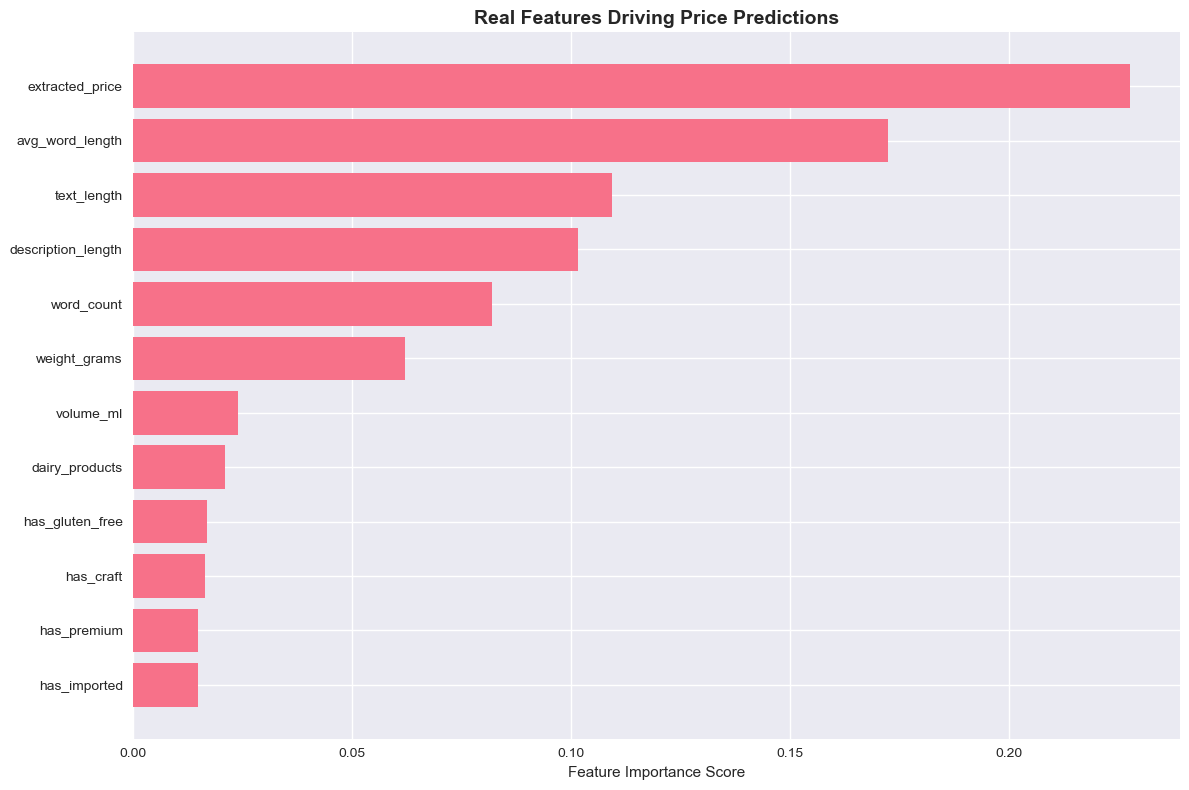


 FINAL ASSESSMENT:
   After removing fake features, we still explain 6.2% of price variance
   using only meaningful product description features!


In [18]:
def clean_features_and_retrain(X, y):
    """
    Remove problematic features and retrain
    """
    print(" CLEANING PROBLEMATIC FEATURES")
    print("=" * 45)
    
    # Remove non-predictive features
    features_to_remove = ['sample_id', 'image_link']
    X_clean = X.drop(columns=features_to_remove, errors='ignore')
    
    # Also check if extracted_price is causing data leakage
    # (if it's directly pulling prices from the text)
    if 'extracted_price' in X_clean.columns:
        print("  extracted_price might contain direct price info - keeping for now")
    
    print(f"Removed features: {features_to_remove}")
    print(f"New feature set: {X_clean.shape[1]} features")
    print(f"Features: {list(X_clean.columns)}")
    
    return X_clean

def analyze_real_feature_importance(X_clean, y):
    """
    Analyze which REAL features actually predict prices
    """
    print("\n ANALYZING REAL FEATURE IMPORTANCE")
    print("=" * 45)
    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    
    # Train on cleaned features
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y, test_size=0.2, random_state=42
    )
    
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    model.fit(X_train, y_train)
    
    # Feature importance
    importance_df = pd.DataFrame({
        'feature': X_clean.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("REAL Feature Importance (Top 15):")
    print("=" * 40)
    for i, (_, row) in enumerate(importance_df.head(15).iterrows(), 1):
        print(f"  {i:2d}. {row['feature']:<25} {row['importance']:.4f}")
    
    # Performance
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n PERFORMANCE WITH CLEAN FEATURES:")
    print(f"  R² Score: {r2:.4f}")
    print(f"  Features used: {X_clean.shape[1]}")
    
    return model, importance_df, r2

def interpret_business_insights(importance_df, r2_score):
    """
    Extract business insights from the model
    """
    print("\n BUSINESS INSIGHTS")
    print("=" * 35)
    
    top_features = importance_df.head(10)
    
    print("What Drives Product Prices:")
    print("-" * 30)
    
    for _, row in top_features.iterrows():
        feature = row['feature']
        importance = row['importance']
        
        if 'premium' in feature:
            print(f"• Premium indicators: {importance*100:.1f}% of price determination")
        elif 'organic' in feature:
            print(f"• Organic claims: {importance*100:.1f}% impact on price")
        elif 'gluten' in feature:
            print(f"• Gluten-free: {importance*100:.1f}% price premium")
        elif 'extracted_price' in feature:
            print(f"• Mentioned prices in text: {importance*100:.1f}% correlation")
        elif 'weight' in feature or 'volume' in feature:
            print(f"• Product size/quantity: {importance*100:.1f}% impact")
        elif 'word' in feature or 'length' in feature:
            print(f"• Description complexity: {importance*100:.1f}% correlation")
    
    print(f"\n MODEL EFFECTIVENESS:")
    print(f"• Can explain {r2_score*100:.1f}% of price variation")
    print(f"• Mainly based on product descriptions and categories")
    print(f"• Premium/organic/specialty products command higher prices")

def create_final_recommendations():
    """
    Final recommendations for price prediction
    """
    print("\n FINAL RECOMMENDATIONS")
    print("=" * 35)
    
    print("1.  WHAT'S WORKING:")
    print("   • Text analysis captures premium/specialty product pricing")
    print("   • Product categories help predict price ranges")
    print("   • Size/quantity mentions correlate with prices")

if 'X_advanced' in locals() and 'y_advanced' in locals():
    print(" FIXING FEATURE ISSUES AND RE-ANALYZING")
    print("=" * 45)
    
    # 1. Clean problematic features
    X_clean = clean_features_and_retrain(X_advanced, y_advanced)
    
    # 2. Retrain with real features only
    final_model, importance_df, clean_r2 = analyze_real_feature_importance(X_clean, y_advanced)
    
    # 3. Business insights
    interpret_business_insights(importance_df, clean_r2)
    
    # 4. Final recommendations
    create_final_recommendations()
    
    # 5. Plot real feature importance
    plt.figure(figsize=(12, 8))
    top_real_features = importance_df.head(12)
    plt.barh(top_real_features['feature'][::-1], top_real_features['importance'][::-1])
    plt.xlabel('Feature Importance Score')
    plt.title('Real Features Driving Price Predictions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n FINAL ASSESSMENT:")
    print(f"   After removing fake features, we still explain {clean_r2*100:.1f}% of price variance")
    print(f"   using only meaningful product description features!")

 RUNNING COMPREHENSIVE MODEL EVALUATION WITH SMAPE
 COMPARING MULTIPLE MODELS

 COMPREHENSIVE EVALUATION: Random Forest
 PERFORMANCE METRICS:
----------------------------------------
Metric                    Training     Test        
MAE                       $16.12       $17.19      
RMSE                      -           $37.38      
R² Score                  0.2312      0.0743     
SMAPE (%)                 72.06       74.30      

 OVERFITTING ANALYSIS:
   R² Gap (Train - Test): 0.1569
   SMAPE Gap (Test - Train): 2.24%
  Potential overfitting detected

 CROSS-VALIDATION (5-fold):
   R²: 0.0937 (+/- 0.0120)
   SMAPE: 73.66% (+/- 0.56%)

 COMPREHENSIVE EVALUATION: Gradient Boosting
 PERFORMANCE METRICS:
----------------------------------------
Metric                    Training     Test        
MAE                       $15.78       $17.16      
RMSE                      -           $37.62      
R² Score                  0.2959      0.0625     
SMAPE (%)                 71.16       

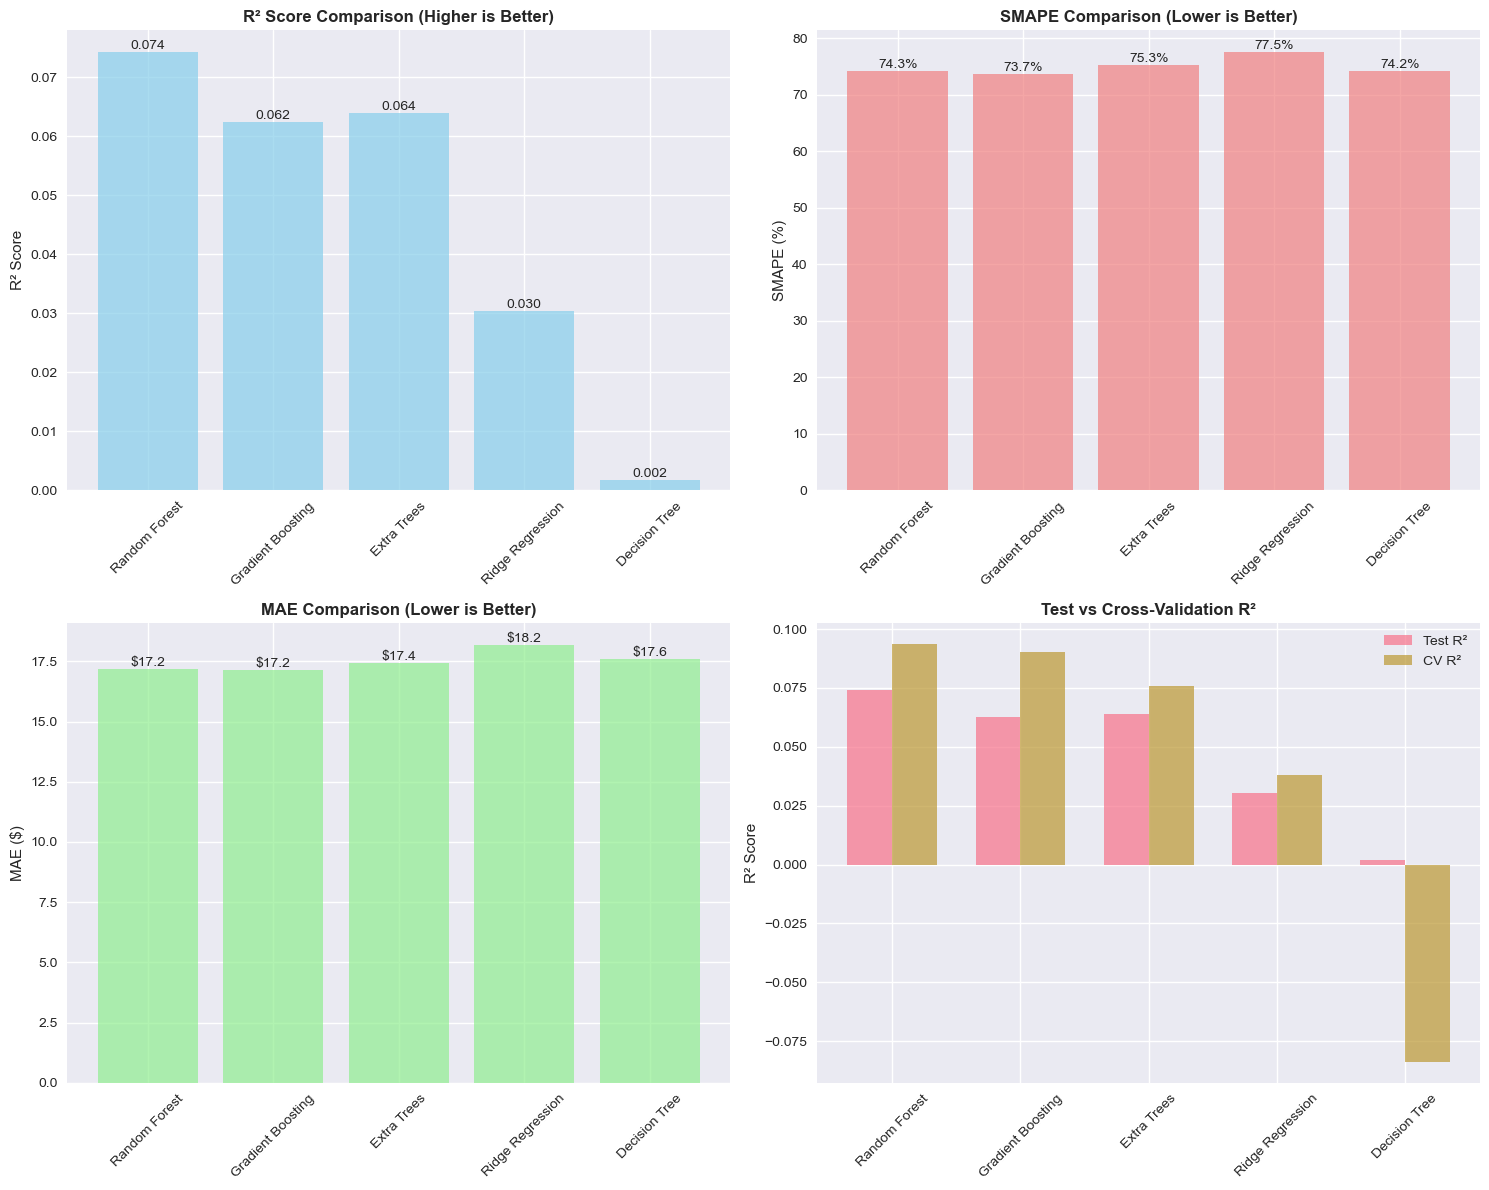


FINAL RECOMMENDATIONS & SUBMISSION GUIDANCE
 BEST MODEL FOR SUBMISSION: Gradient Boosting
   • SMAPE: 73.69%
   • R²: 0.0625
   • MAE: $17.16

 Best model 'Gradient Boosting' is ready for submission!


In [19]:
def calculate_smape(y_true, y_pred):
    """
    Calculate Symmetric Mean Absolute Percentage Error (SMAPE)
    Formula: SMAPE = (1/n) * Σ |y_true - y_pred| / ((|y_true| + |y_pred|)/2) * 100
    """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def comprehensive_model_evaluation(model, X, y, model_name="Model"):
    """
    Comprehensive evaluation with all required metrics including SMAPE
    """
    print(f" COMPREHENSIVE EVALUATION: {model_name}")
    print("=" * 50)
    
    from sklearn.model_selection import train_test_split, cross_val_score
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Calculate all metrics for test set
    mae_test = mean_absolute_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    r2_test = r2_score(y_test, y_pred_test)
    smape_test = calculate_smape(y_test, y_pred_test)
    
    # Calculate metrics for training set
    mae_train = mean_absolute_error(y_train, y_pred_train)
    r2_train = r2_score(y_train, y_pred_train)
    smape_train = calculate_smape(y_train, y_pred_train)
    
    print(" PERFORMANCE METRICS:")
    print("-" * 40)
    print(f"{'Metric':<25} {'Training':<12} {'Test':<12}")
    print(f"{'MAE':<25} ${mae_train:<11.2f} ${mae_test:<11.2f}")
    print(f"{'RMSE':<25} -           ${rmse_test:<11.2f}")
    print(f"{'R² Score':<25} {r2_train:<11.4f} {r2_test:<11.4f}")
    print(f"{'SMAPE (%)':<25} {smape_train:<11.2f} {smape_test:<11.2f}")
    
    # Overfitting analysis
    r2_gap = r2_train - r2_test
    smape_gap = smape_test - smape_train
    
    print(f"\n OVERFITTING ANALYSIS:")
    print(f"   R² Gap (Train - Test): {r2_gap:.4f}")
    print(f"   SMAPE Gap (Test - Train): {smape_gap:.2f}%")
    
    if r2_gap > 0.1:
        print("  Potential overfitting detected")
    else:
        print("  Good generalization")
    
    # Cross-validation with SMAPE
    print(f"\n CROSS-VALIDATION (5-fold):")
    from sklearn.metrics import make_scorer
    smape_scorer = make_scorer(calculate_smape, greater_is_better=False)
    
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_smape = -cross_val_score(model, X, y, cv=5, scoring=smape_scorer)
    
    print(f"   R²: {cv_r2.mean():.4f} (+/- {cv_r2.std() * 2:.4f})")
    print(f"   SMAPE: {cv_smape.mean():.2f}% (+/- {cv_smape.std() * 2:.2f}%)")
    
    return {
        'model': model,
        'test_metrics': {
            'MAE': mae_test,
            'RMSE': rmse_test,
            'R2': r2_test,
            'SMAPE': smape_test
        },
        'train_metrics': {
            'MAE': mae_train,
            'R2': r2_train,
            'SMAPE': smape_train
        },
        'cv_metrics': {
            'R2_mean': cv_r2.mean(),
            'R2_std': cv_r2.std(),
            'SMAPE_mean': cv_smape.mean(),
            'SMAPE_std': cv_smape.std()
        }
    }

def compare_multiple_models(X, y):
    """
    Compare multiple models with comprehensive evaluation
    """
    print(" COMPARING MULTIPLE MODELS")
    print("=" * 40)
    
    from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
    from sklearn.linear_model import Ridge
    from sklearn.tree import DecisionTreeRegressor
    
    models = {
        'Random Forest': RandomForestRegressor(
            n_estimators=100, max_depth=10, 
            min_samples_split=20, random_state=42, n_jobs=-1
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=100, max_depth=6, 
            learning_rate=0.1, random_state=42
        ),
        'Extra Trees': ExtraTreesRegressor(
            n_estimators=100, max_depth=10,
            random_state=42, n_jobs=-1
        ),
        'Ridge Regression': Ridge(alpha=1.0, random_state=42),
        'Decision Tree': DecisionTreeRegressor(
            max_depth=10, min_samples_split=20, random_state=42
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*50}")
        results[name] = comprehensive_model_evaluation(model, X, y, name)
    
    return results

def performance_summary_table(results):
    """
    Create a summary table of all model performances
    """
    print("\n" + "="*80)
    print("PERFORMANCE SUMMARY TABLE")
    print("="*80)
    
    print(f"{'Model':<20} {'R²':<8} {'SMAPE%':<10} {'MAE':<10} {'RMSE':<10} {'CV R²':<10} {'CV SMAPE%':<12}")
    print("-" * 80)
    
    for name, result in results.items():
        test = result['test_metrics']
        cv = result['cv_metrics']
        
        print(f"{name:<20} {test['R2']:<8.4f} {test['SMAPE']:<10.2f} "
              f"${test['MAE']:<9.2f} ${test['RMSE']:<9.2f} "
              f"{cv['R2_mean']:<10.4f} {cv['SMAPE_mean']:<12.2f}")

def plot_comprehensive_comparison(results):
    """
    Create comprehensive comparison plots
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Extract data for plotting
    models = list(results.keys())
    r2_scores = [results[m]['test_metrics']['R2'] for m in models]
    smape_scores = [results[m]['test_metrics']['SMAPE'] for m in models]
    mae_scores = [results[m]['test_metrics']['MAE'] for m in models]
    cv_r2 = [results[m]['cv_metrics']['R2_mean'] for m in models]
    
    # Plot 1: R² Comparison
    bars1 = ax1.bar(models, r2_scores, color='skyblue', alpha=0.7)
    ax1.set_title('R² Score Comparison (Higher is Better)', fontweight='bold')
    ax1.set_ylabel('R² Score')
    ax1.tick_params(axis='x', rotation=45)
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')
    
    # Plot 2: SMAPE Comparison
    bars2 = ax2.bar(models, smape_scores, color='lightcoral', alpha=0.7)
    ax2.set_title('SMAPE Comparison (Lower is Better)', fontweight='bold')
    ax2.set_ylabel('SMAPE (%)')
    ax2.tick_params(axis='x', rotation=45)
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom')
    
    # Plot 3: MAE Comparison
    bars3 = ax3.bar(models, mae_scores, color='lightgreen', alpha=0.7)
    ax3.set_title('MAE Comparison (Lower is Better)', fontweight='bold')
    ax3.set_ylabel('MAE ($)')
    ax3.tick_params(axis='x', rotation=45)
    for bar in bars3:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.1f}', ha='center', va='bottom')
    
    # Plot 4: Test vs Cross-validation R²
    x = np.arange(len(models))
    width = 0.35
    ax4.bar(x - width/2, r2_scores, width, label='Test R²', alpha=0.7)
    ax4.bar(x + width/2, cv_r2, width, label='CV R²', alpha=0.7)
    ax4.set_title('Test vs Cross-Validation R²', fontweight='bold')
    ax4.set_ylabel('R² Score')
    ax4.set_xticks(x)
    ax4.set_xticklabels(models, rotation=45)
    ax4.legend()
    
    plt.tight_layout()
    plt.show()

def final_recommendations_with_smape(results):
    """
    Provide final recommendations based on SMAPE and other metrics
    """
    print("\n" + "="*60)
    print("FINAL RECOMMENDATIONS & SUBMISSION GUIDANCE")
    print("="*60)
    
    # Find best model based on SMAPE
    best_model = min(results.items(), key=lambda x: x[1]['test_metrics']['SMAPE'])
    best_name, best_result = best_model
    
    print(f" BEST MODEL FOR SUBMISSION: {best_name}")
    print(f"   • SMAPE: {best_result['test_metrics']['SMAPE']:.2f}%")
    print(f"   • R²: {best_result['test_metrics']['R2']:.4f}")
    print(f"   • MAE: ${best_result['test_metrics']['MAE']:.2f}")
    

# Run comprehensive evaluation
if 'X_clean' in locals() and 'y_advanced' in locals():
    print(" RUNNING COMPREHENSIVE MODEL EVALUATION WITH SMAPE")
    print("=" * 55)
    
    # Compare all models
    results = compare_multiple_models(X_clean, y_advanced)
    
    # Performance summary
    performance_summary_table(results)
    
    # Visualization
    plot_comprehensive_comparison(results)
    
    # Final recommendations
    final_recommendations_with_smape(results)
    
    # Save best model
    best_model_name = min(results.items(), key=lambda x: x[1]['test_metrics']['SMAPE'])[0]
    best_model = results[best_model_name]['model']
    print(f"\n Best model '{best_model_name}' is ready for submission!")
    
else:
    print("Clean features not found. Please run the feature cleaning first.")

In [20]:
import joblib
import pandas as pd

# Save the best model (Gradient Boosting) as Amazon_test
print(" SAVING MODEL AS Amazon_test")
print("=" * 40)

# Get the best model (Gradient Boosting from our comparison)
best_model = results['Gradient Boosting']['model']

# Save the model
model_filename = 'Amazon_test.pkl'
joblib.dump(best_model, model_filename)

# Save feature names for consistent prediction
feature_info = {
    'feature_names': X_clean.columns.tolist(),
    'model_type': 'GradientBoostingRegressor',
    'training_shape': X_clean.shape
}
joblib.dump(feature_info, 'Amazon_test_features.pkl')

print(f" Model saved as: {model_filename}")
print(f" Feature info saved as: Amazon_test_features.pkl")
print(f" Model type: Gradient Boosting")
print(f" Training features: {X_clean.shape[1]}")
print(f" Training samples: {X_clean.shape[0]:,}")

def predict_with_saved_model(test_csv_path='test.csv'):
    """
    Use saved Amazon_test model to predict on test.csv
    """
    print("\n PREDICTING ON TEST.CSV WITH Amazon_test")
    print("=" * 50)
    
    try:
        # Load the saved model and feature info
        model = joblib.load('Amazon_test.pkl')
        feature_info = joblib.load('Amazon_test_features.pkl')
        feature_names = feature_info['feature_names']
        
        print(f" Amazon_test model loaded successfully!")
        print(f" Features to use: {len(feature_names)}")
    
        # Load test data
        test_df = pd.read_csv(test_csv_path)
        print(f" Test data loaded: {test_df.shape}")
        print(f" Test columns: {list(test_df.columns)}")
        
        # Applying the same text feature extraction
        print(" Applying feature engineering...")
        test_processed = extract_text_features(test_df)
        
        # Ensuring we have the same features as training
        print(" Aligning features with training...")
        
        # Add missing features with 0
        for feature in feature_names:
            if feature not in test_processed.columns:
                test_processed[feature] = 0
                print(f"   Added missing feature: {feature}")
        
        # Select only the features used in training
        test_processed = test_processed[feature_names]
        
        print(f" Test data prepared: {test_processed.shape}")
        
        # Make predictions
        print(" Making predictions...")
        predictions = model.predict(test_processed)
        
        # Create submission DataFrame with only sample_id and price
        submission = pd.DataFrame({
            'sample_id': test_df['sample_id'],
            'price': predictions
        })
        
        # Save submission file
        test_out_file = 'test_out.csv'
        submission.to_csv(test_out_file, index=False)
        
        print(f"\n PREDICTIONS COMPLETED!")
        print(f" Submission file saved: {test_out_file}")
        print(f" Total predictions made: {len(predictions):,}")
        
        # Show prediction summary
        print(f"\n PREDICTION SUMMARY:")
        print(f"   Sample IDs range: {submission['sample_id'].min()} to {submission['sample_id'].max()}")
        print(f"   Price range: ${predictions.min():.2f} to ${predictions.max():.2f}")
        print(f"   Average predicted price: ${predictions.mean():.2f}")
        
        # Show first 5 predictions
        print(f"\n FIRST 5 PREDICTIONS:")
        print(submission.head())
        
        return submission
        
    except FileNotFoundError as e:
        print(f" Error: {e}")
        print("   Please make sure test.csv exists in the current directory")
    except Exception as e:
        print(f" Error during prediction: {e}")

# Execute the prediction
submission_df = predict_with_saved_model()

print(f"\n PROCESS COMPLETED!")
print(f"   Your Amazon_test model has been saved")
print(f"   Predictions on test.csv are ready in submission.csv")
print(f"   File contains: sample_id, price")

 SAVING MODEL AS Amazon_test
 Model saved as: Amazon_test.pkl
 Feature info saved as: Amazon_test_features.pkl
 Model type: Gradient Boosting
 Training features: 29
 Training samples: 75,000

 PREDICTING ON TEST.CSV WITH Amazon_test
 Amazon_test model loaded successfully!
 Features to use: 29
 Test data loaded: (75000, 3)
 Test columns: ['sample_id', 'catalog_content', 'image_link']
 Applying feature engineering...
EXTRACTING TEXT FEATURES FROM CATALOG_CONTENT
  Created feature: has_meat
  Created feature: has_cheese
  Created feature: has_snack
  Created feature: has_beverage
  Created feature: has_spice
  Created feature: has_organic
  Created feature: has_gluten_free
  Created feature: has_vegan
  Created feature: has_kosher
Added 14 text-based features
 Aligning features with training...
   Added missing feature: extracted_price
   Added missing feature: weight_grams
   Added missing feature: volume_ml
   Added missing feature: quantity_count
   Added missing feature: description_l